In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = Config.data_path()/'histo-cancer-detection'

In [4]:
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/histo-cancer-detection/train_labels.csv'),
 PosixPath('/home/ubuntu/.fastai/data/histo-cancer-detection/train'),
 PosixPath('/home/ubuntu/.fastai/data/histo-cancer-detection/models'),
 PosixPath('/home/ubuntu/.fastai/data/histo-cancer-detection/test'),
 PosixPath('/home/ubuntu/.fastai/data/histo-cancer-detection/sample_submission.csv')]

In [5]:
tr_df = pd.read_csv(path/'train_labels.csv')

In [6]:
te_df = pd.read_csv(path/'sample_submission.csv')

In [7]:
tr_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [8]:
tr_df.label.mean()

0.40503124644926713

In [9]:
tr_df.id.nunique()

220025

In [10]:
te_df.id.nunique()

57458

In [11]:
fnames = get_image_files(path/'test')

In [12]:
im = open_image(fnames[100])

(torch.Size([3, 96, 96]), None)

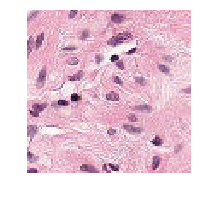

In [13]:
im.shape, im.show()

### Data prep

In [14]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [15]:
np.random.seed(42)

In [16]:
bs = 256
sz = 96

In [17]:
src = (ImageItemList.from_csv(path=path, csv_name='train_labels.csv',
                              folder='train', suffix='.tif')
                    .random_split_by_pct(0.2)
                    .label_from_df()
                    .add_test_folder())

In [18]:
data = (src.transform(tfms, size=sz)
        .databunch(bs=bs).normalize(imagenet_stats))

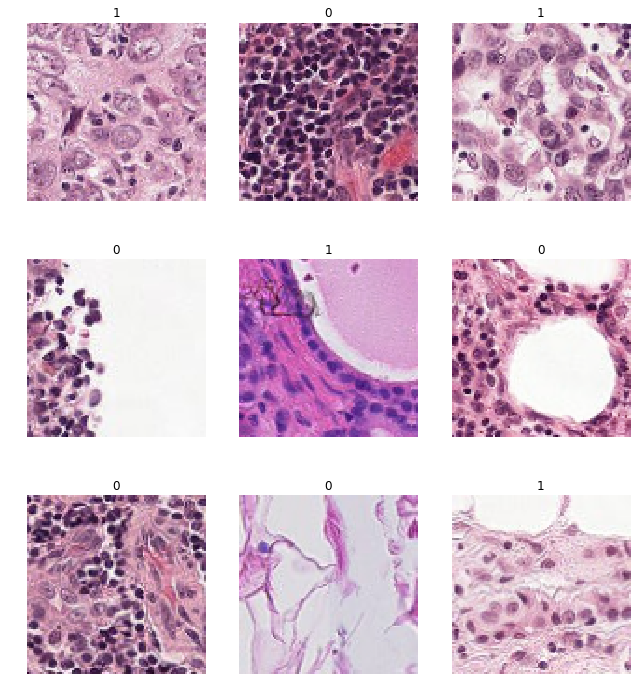

In [19]:
data.show_batch(3)

In [20]:
data

ImageDataBunch;
Train: LabelList
y: CategoryList (176020 items)
[Category 0, Category 1, Category 0, Category 0, Category 0]...
Path: /home/ubuntu/.fastai/data/histo-cancer-detection
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/ubuntu/.fastai/data/histo-cancer-detection;
Valid: LabelList
y: CategoryList (44005 items)
[Category 0, Category 1, Category 0, Category 0, Category 1]...
Path: /home/ubuntu/.fastai/data/histo-cancer-detection
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/ubuntu/.fastai/data/histo-cancer-detection;
Test: LabelList
y: CategoryList (57458 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: /home/ubuntu/.fastai/data/histo-cancer-detection
x: ImageItemList (57458 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image

In [21]:
arch = models.resnet34

In [22]:
learn = create_cnn(data, arch, metrics=accuracy)

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


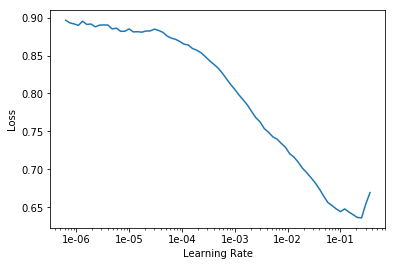

In [24]:
learn.recorder.plot()

In [25]:
lr = 1e-2/2

In [26]:
learn.fit_one_cycle(5, slice(lr))

Total time: 26:03
epoch  train_loss  valid_loss  accuracy
1      0.246435    0.211010    0.916555  (05:14)
2      0.199351    0.205006    0.921054  (05:12)
3      0.181544    0.159223    0.939848  (05:12)
4      0.165016    0.147304    0.945006  (05:12)
5      0.155391    0.145646    0.945529  (05:11)



In [27]:
learn.save('stage-1-rn34')

In [23]:
learn.load('stage-1-rn34')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (176020 items)
[Category 0, Category 1, Category 0, Category 0, Category 0]...
Path: /home/ubuntu/.fastai/data/histo-cancer-detection
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/ubuntu/.fastai/data/histo-cancer-detection;
Valid: LabelList
y: CategoryList (44005 items)
[Category 0, Category 1, Category 0, Category 0, Category 1]...
Path: /home/ubuntu/.fastai/data/histo-cancer-detection
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/ubuntu/.fastai/data/histo-cancer-detection;
Test: LabelList
y: CategoryList (57458 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: /home/ubuntu/.fastai/data/histo-cancer-detection
x: ImageItemList (57458 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 9

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

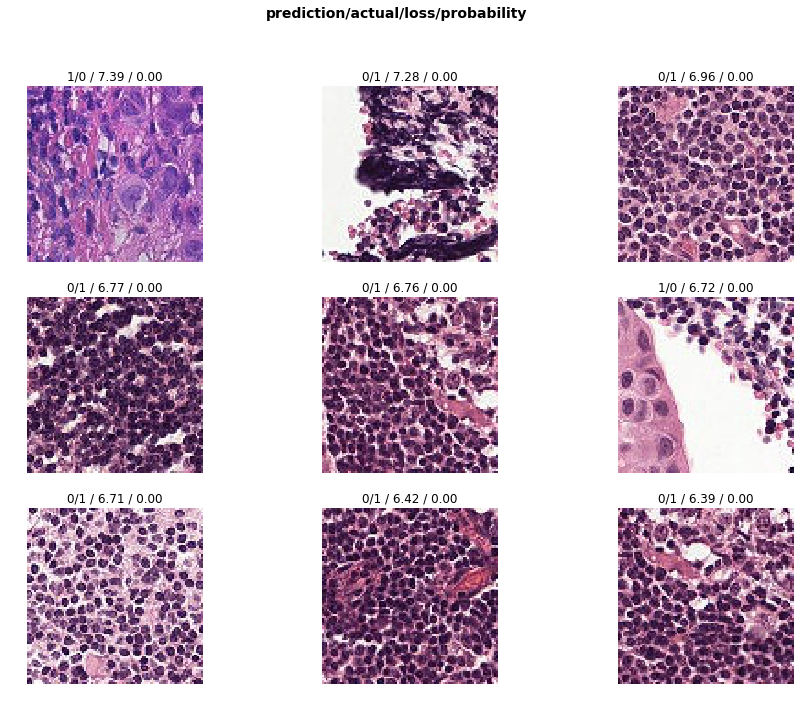

In [28]:
interp.plot_top_losses(9, figsize=(15,11))

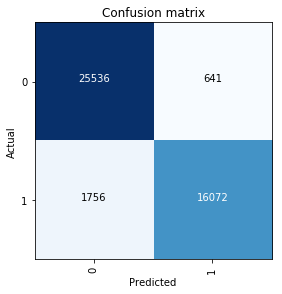

In [36]:
interp.plot_confusion_matrix()

In [37]:
learn.unfreeze()

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


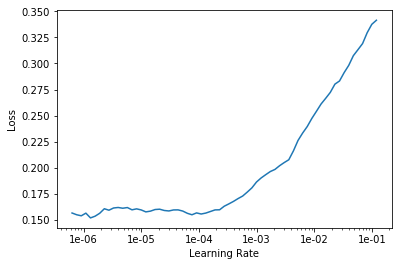

In [39]:
learn.recorder.plot()

In [40]:
lr = 1e-3

In [41]:
learn.fit_one_cycle(5, slice(lr/100, lr))

Total time: 37:26
epoch  train_loss  valid_loss  accuracy
1      0.154728    0.145727    0.946847  (07:31)
2      0.147783    0.122159    0.955301  (07:29)
3      0.127551    0.106827    0.961936  (07:28)
4      0.106483    0.090959    0.968004  (07:27)
5      0.091315    0.088728    0.969094  (07:29)



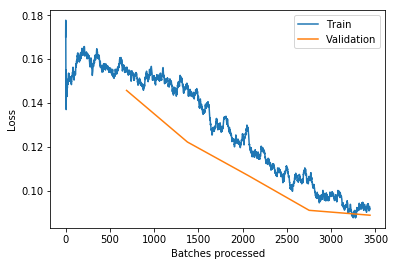

In [42]:
learn.recorder.plot_losses()

In [43]:
learn.save('stage-2-rn34')

In [23]:
learn.load('stage-2-rn34')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (176020 items)
[Category 0, Category 1, Category 0, Category 0, Category 0]...
Path: /home/ubuntu/.fastai/data/histo-cancer-detection
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/ubuntu/.fastai/data/histo-cancer-detection;
Valid: LabelList
y: CategoryList (44005 items)
[Category 0, Category 1, Category 0, Category 0, Category 1]...
Path: /home/ubuntu/.fastai/data/histo-cancer-detection
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/ubuntu/.fastai/data/histo-cancer-detection;
Test: LabelList
y: CategoryList (57458 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: /home/ubuntu/.fastai/data/histo-cancer-detection
x: ImageItemList (57458 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 9

In [44]:
interp = ClassificationInterpretation.from_learner(learn)

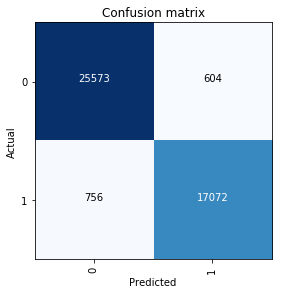

In [45]:
interp.plot_confusion_matrix()

### Predict 

In [24]:
from sklearn import metrics

In [46]:
preds, target_values =  learn.get_preds(ds_type=DatasetType.Valid)

In [25]:
preds, target_values =  learn.TTA(ds_type=DatasetType.Valid)

Total time: 05:52



In [47]:
preds.shape, target_values.shape

(torch.Size([44005, 2]), torch.Size([44005]))

In [48]:
# no TTA
metrics.roc_auc_score(target_values, preds[:,1])

0.9942159296909101

In [26]:
# with TTA
metrics.roc_auc_score(target_values, preds[:,1])

0.9849449945050132

In [49]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
preds, _ = learn.TTA(ds_type=DatasetType.Test)

In [50]:
def get_image_names(data):
    return [fn.stem for fn in data.test_dl.x.items]

In [51]:
test_ids = get_image_names(data)

In [43]:
te_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [52]:
subm_df = pd.DataFrame({'id':test_ids, 'label':preds[:,1]})

In [48]:
all(subm_df.id == te_df.id)

False

In [53]:
subm_fname = 'hist2-st2-34.csv'

In [54]:
subm_df.to_csv(f'data/submits/{subm_fname}', index=False, header=True)

In [55]:
! kaggle competitions submit -c histopathologic-cancer-detection -f data/submits/{subm_fname} -m ""

100%|██████████████████████████████████████| 2.89M/2.89M [00:01<00:00, 1.81MB/s]
Successfully submitted to Histopathologic Cancer Detection